In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
layers = keras.layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.applications import VGG16
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("keras version", keras.__version__)
print("numpy version", np.__version__)

keras version 2.11.0
numpy version 1.22.4


In [2]:
import cv2

print(cv2.__version__)


4.6.0


In [3]:
# download Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# normalize to [0,1] train and test images
train_images = train_images.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [5]:
len(train_images)

60000

In [6]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [7]:
img_rows = 32
img_cols = 32
input_shape = (img_rows, img_cols, 3)


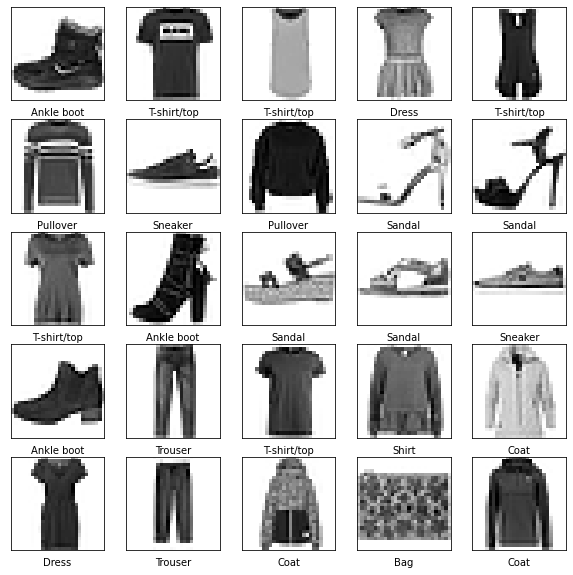

In [8]:
#### check the data we got
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images[i]).astype(int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

In [9]:
train_images_rgb = np.array(
    [cv2.cvtColor(cv2.resize(img, (img_rows, img_cols)),
                  cv2.COLOR_GRAY2RGB) for img in train_images])

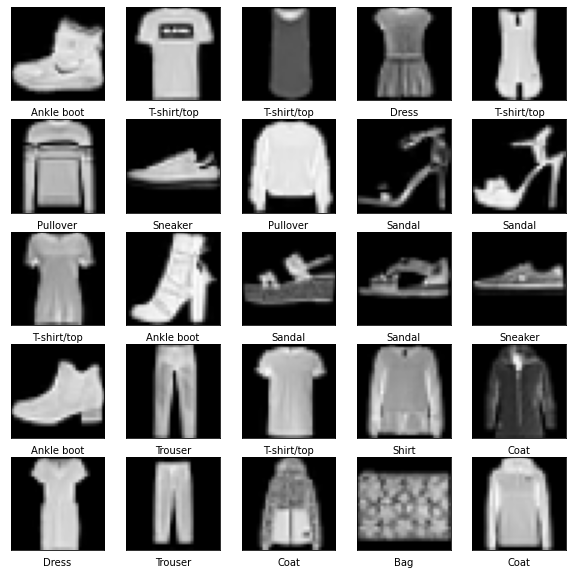

In [10]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images_rgb[i]).astype(int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

In [11]:
# converting to category vectors
train_labels = to_categorical(train_labels)
y_test = to_categorical(y_test)

Let's split the original training data into 80% training and 20% validation. This helps to see weather we're over-fitting on the training data and weather we should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

### Model VGG 16
VGG16 is a convolution neural net architecture that's used for image recognition. It utilizes 16 layers with weights and is considered one of the best vision model architectures to date.

In [26]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape))

In [13]:
# since the size of our images is diff. we need to reshape them to e.g. (32, 32, 3) (also for X_test)
train_images = np.array([cv2.resize(img, (img_rows, img_cols)) for img in train_images])
X_test = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_test])
print(train_images.shape)
print(X_test.shape)

(60000, 32, 32)
(10000, 32, 32)


In [14]:
# convert grayscale images to RGB
train_images = np.stack((train_images,) * 3, axis=-1)
X_test = np.stack((X_test,) * 3, axis=-1)
print(train_images.shape)
print(X_test.shape)


(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [15]:
from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=12345)

In [16]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

In [17]:
vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### Model Architecture: VGG16 as a base of our CNN model


In [18]:
# freezing the convolutional layers of VGG16
for layer in vgg.layers:
    layer.trainable = False

In [19]:
# let's create dense layers on top of vgg16

model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.2))
model_vgg.add(Dense(10, activation='softmax'))

model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


### Training preparations
fter building the CNN model, we have to compile it. Use Adam optimizer instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data

In [27]:
from tensorflow.keras.optimizers.legacy import Adam

# model_vgg.compile(loss='sparse_categorical_crossentropy',
#               optimizer=Adam(learning_rate=2e-4),
#               metrics=['acc'])
model_vgg.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc'])
# model_vgg.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=["acc"]) # loss='sparse_categorical_crossentropy',

### Training

In [28]:
# training the model
batch_size = 64

history = model_vgg.fit(train_images, train_labels, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
938/938 [==============================] - 935s 997ms/step - loss: 1.0206 - acc: 0.6705 - val_loss: 0.6473 - val_acc: 0.7833
Epoch 2/10
938/938 [==============================] - 830s 885ms/step - loss: 0.6064 - acc: 0.7893 - val_loss: 0.5473 - val_acc: 0.8077
Epoch 3/10
938/938 [==============================] - 854s 910ms/step - loss: 0.5359 - acc: 0.8109 - val_loss: 0.5047 - val_acc: 0.8214
Epoch 4/10
938/938 [==============================] - 856s 913ms/step - loss: 0.4951 - acc: 0.8235 - val_loss: 0.4781 - val_acc: 0.8314
Epoch 5/10
938/938 [==============================] - 811s 865ms/step - loss: 0.4691 - acc: 0.8326 - val_loss: 0.4565 - val_acc: 0.8348
Epoch 6/10
938/938 [==============================] - 820s 875ms/step - loss: 0.4486 - acc: 0.8400 - val_loss: 0.4438 - val_acc: 0.8397
Epoch 7/10
938/938 [==============================] - 824s 879ms/step - loss: 0.4329 - acc: 0.8450 - val_loss: 0.4348 - val_acc: 0.8432
Epoch 8/10
938/938 [============================

### Model Evaluation

In [29]:
test_loss, test_acc = model_vgg.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")
     

313/313 [==============================] - 117s 375ms/step - loss: 0.4063 - acc: 0.8528
Test loss: 0.4063435196876526
Test accuracy: 0.8528000116348267


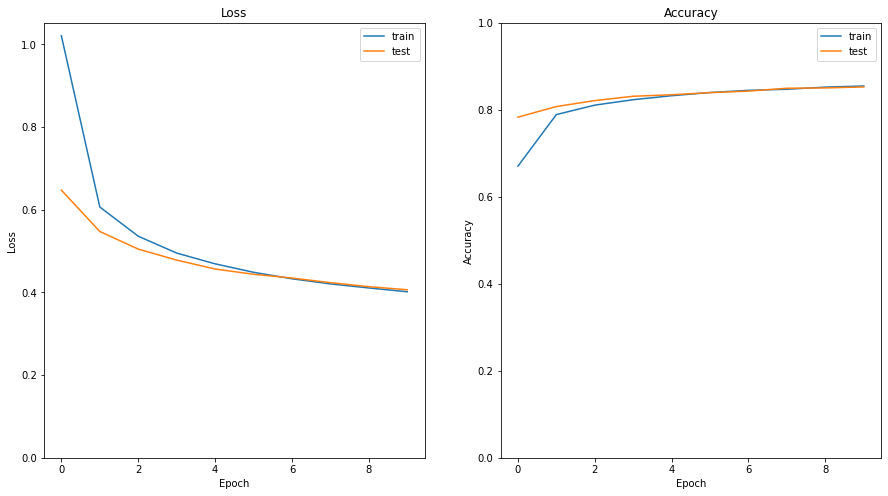

In [31]:
def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax[0].plot(history.history['loss'])
    if validation:
        ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim(bottom=0.)
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['train', 'test'])
    
    # plot history for F score etc.
    ax[1].plot(history.history['acc'])
    if validation:
        ax[1].plot(history.history['val_acc'])
    ax[1].set_title('Accuracy')
    ax[1].set_ylim(bottom=0., top=1.0)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['train', 'test'])

plot_history(history, validation=True)

313/313 [==============================] - 126s 403ms/step


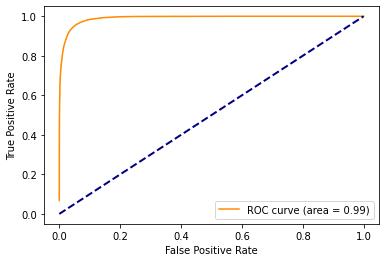

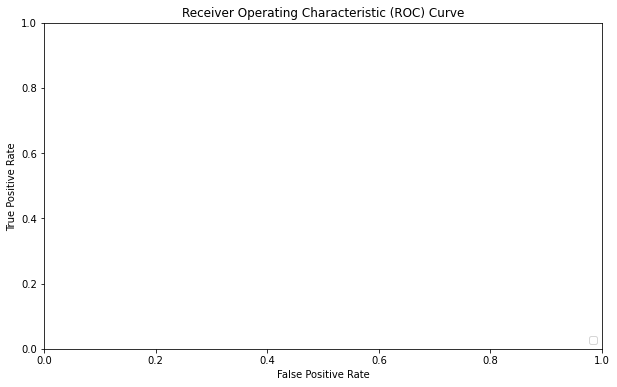

In [38]:
# let's have alook on ROC 
y_scores = model_vgg.predict(X_test)
# calculate ROC and get rates: FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_scores.ravel())
roc_auc = auc(fpr, tpr)
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})


sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=roc_df, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='navy', lw=2, linestyle='--')

plt.figure(figsize=(10, 6))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

313/313 [==============================] - 143s 453ms/step


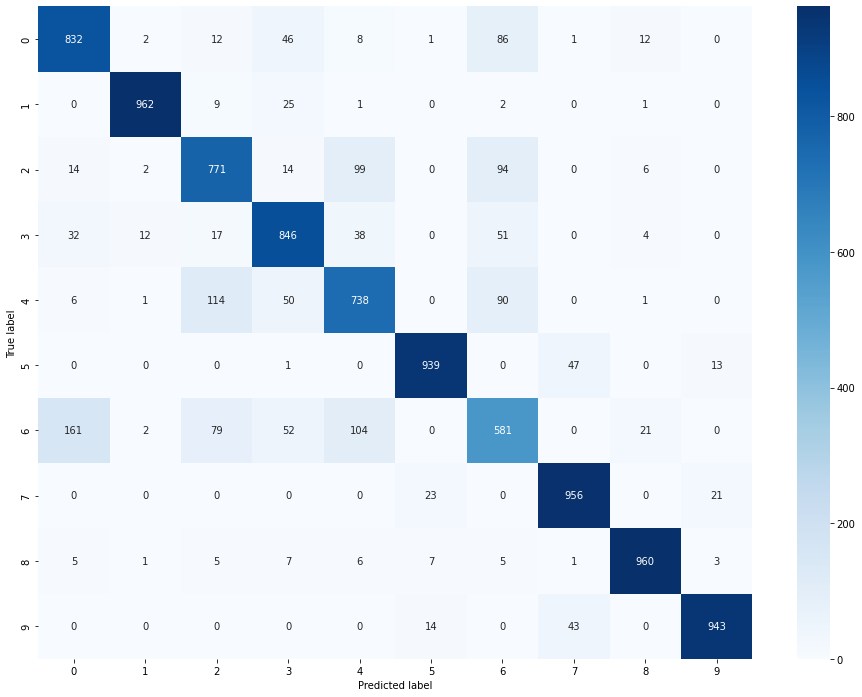

In [40]:
# check the Confusion Matrix
y_pred = model_vgg.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Summary 

Test accuracy: ~85%. From the Comparison of the Loss for the train and test data we see that we are already on limit of the number of epoch sice soonish the model would be overfitted. The ROC curve looks a bit strange to me. 

